<a href="https://colab.research.google.com/github/ichsanelf/Moekai-DeepLearningModel-CapstoneProject/blob/main/klasifikasiGambar_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise



In [ ]:
#!pip install tensorflow==2.15.0

In [ ]:
import tensorflow as tf
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.17.1


In [ ]:
# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input, Embedding, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet, MobileNetV2
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Collecting

In [ ]:
!kaggle datasets download -d aditmagotra/gameplay-images
!unzip gameplay-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Genshin Impact/image_1.png  
  inflating: Dataset/Genshin Impact/image_10.png  
  inflating: Dataset/Genshin Impact/image_100.png  
  inflating: Dataset/Genshin Impact/image_1000.png  
  inflating: Dataset/Genshin Impact/image_1001.png  
  inflating: Dataset/Genshin Impact/image_1002.png  
  inflating: Dataset/Genshin Impact/image_1003.png  
  inflating: Dataset/Genshin Impact/image_1004.png  
  inflating: Dataset/Genshin Impact/image_1005.png  
  inflating: Dataset/Genshin Impact/image_1006.png  
  inflating: Dataset/Genshin Impact/image_1007.png  
  inflating: Dataset/Genshin Impact/image_1008.png  
  inflating: Dataset/Genshin Impact/image_1009.png  
  inflating: Dataset/Genshin Impact/image_101.png  
  inflating: Dataset/Genshin Impact/image_1010.png  
  inflating: Dataset/Genshin Impact/image_1011.png  
  inflating: Dataset/Genshin Impact/image_1012.png  
  inflating: Dataset/Genshin Impact/image_1013.png  
  

In [ ]:
# Define the base path
path = "Dataset/"

# Initialize the dictionary
human_emotion = {}

# Iterate through each subfolder and collect images
for folder in os.listdir(path):
    folder_path = os.path.join(path, folder)
    if os.path.isdir(folder_path):  # Check if it is a directory
        images = []
        for filename in os.listdir(folder_path):
            if filename.endswith(('.png', '.jpg', '.jpeg')):  # Filter image files
                images.append(os.path.join(folder_path, filename))
        human_emotion[folder] = images

# Print the dictionary to check the result
print(human_emotion.keys())

dict_keys(['Forza Horizon', 'Free Fire', 'God of War', 'Roblox', 'Among Us', 'Fortnite', 'Terraria', 'Minecraft', 'Apex Legends', 'Genshin Impact'])


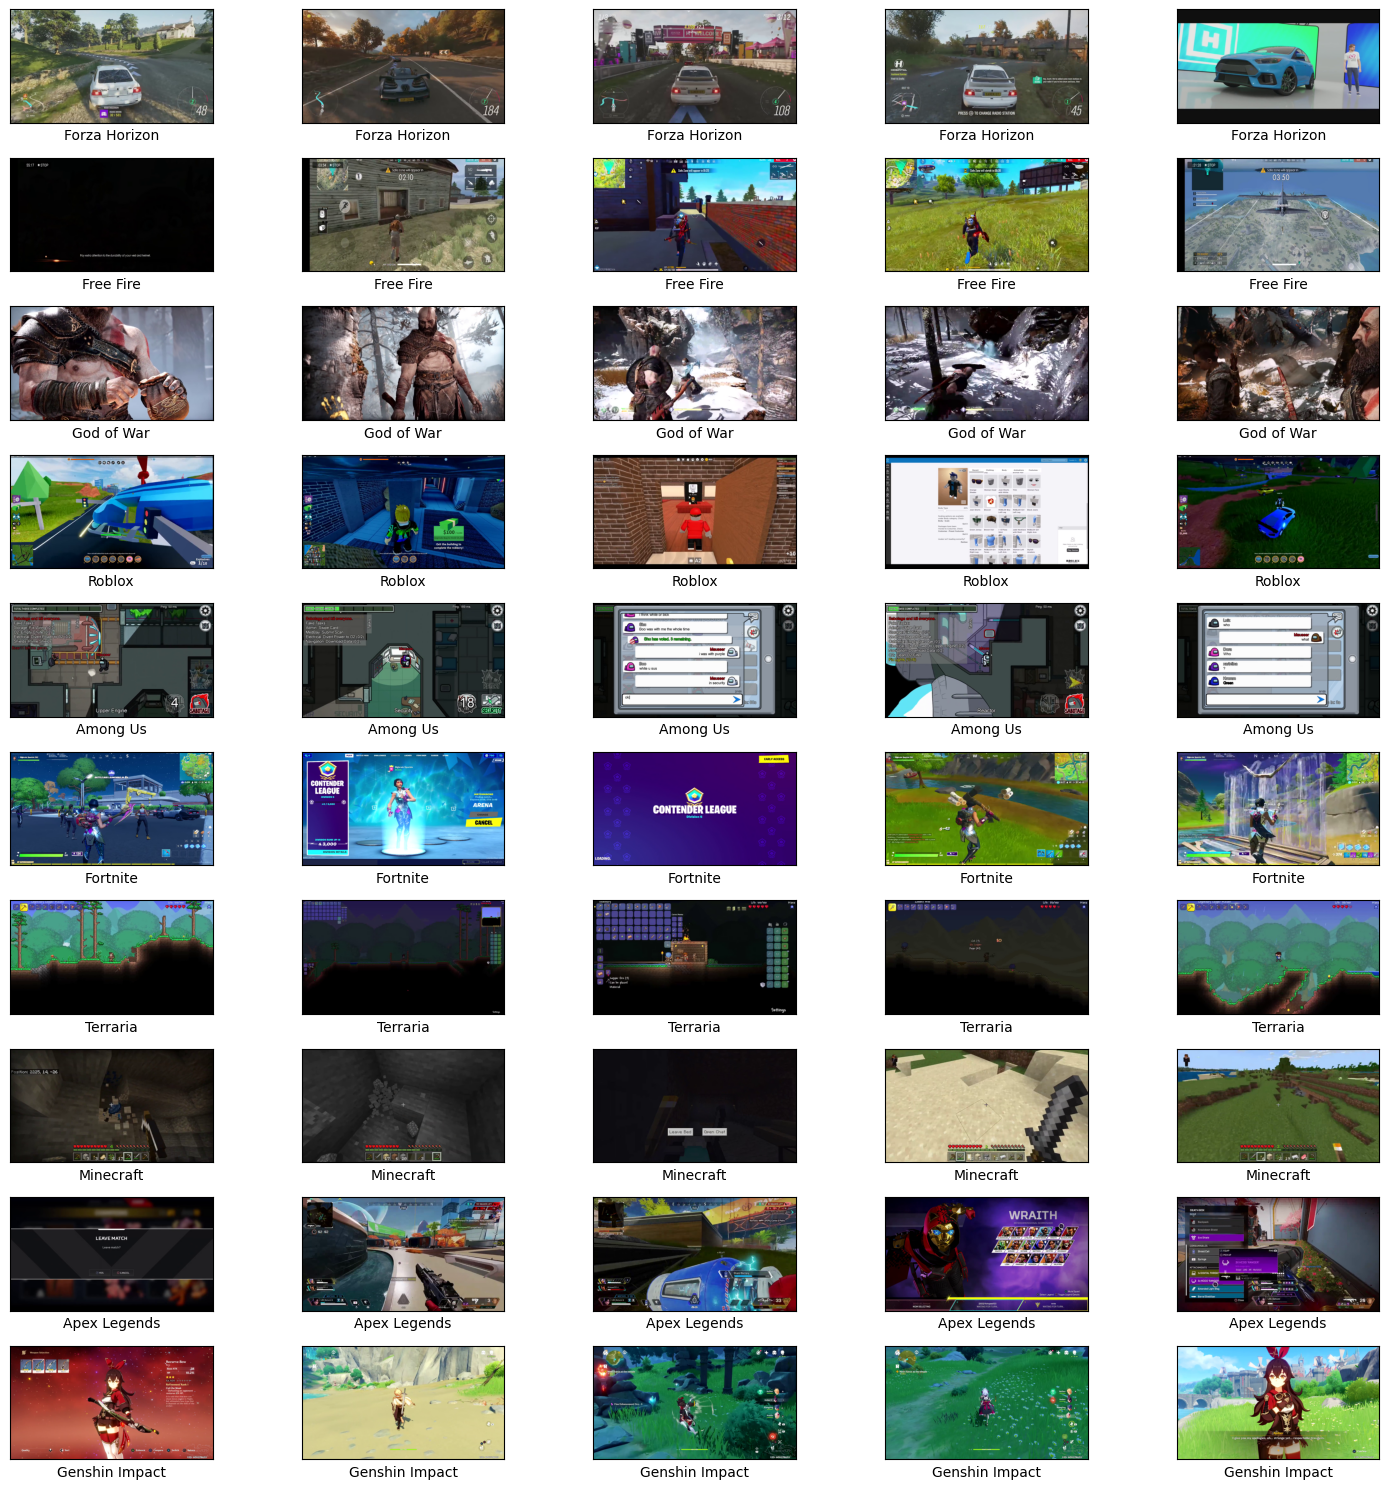

In [ ]:
# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(human_emotion.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(human_emotion.keys()):
    images = np.random.choice(human_emotion[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = human_emotion[class_name][j]
        img = Image.open(img_path)  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

# Data Splitting

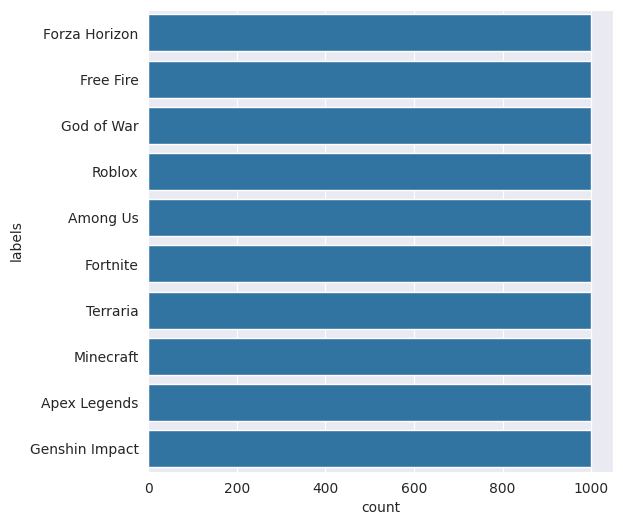

In [ ]:
# Define source path
game_path = "Dataset/"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(game_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

images_df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = images_df['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [ ]:
images_df

,path,file_name,labels
0,Dataset/Forza Horizon/image_749.png,image_749.png,Forza Horizon
1,Dataset/Forza Horizon/image_53.png,image_53.png,Forza Horizon
2,Dataset/Forza Horizon/image_993.png,image_993.png,Forza Horizon
3,Dataset/Forza Horizon/image_912.png,image_912.png,Forza Horizon
4,Dataset/Forza Horizon/image_291.png,image_291.png,Forza Horizon
...,...,...,...
9995,Dataset/Genshin Impact/image_599.png,image_599.png,Genshin Impact
9996,Dataset/Genshin Impact/image_513.png,image_513.png,Genshin Impact
9997,Dataset/Genshin Impact/image_841.png,image_841.png,Genshin Impact
9998,Dataset/Genshin Impact/image_590.png,image_590.png,Genshin Impact


In [ ]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X= images_df['path']
y= images_df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [ ]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [ ]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('train size', len(df_tr))
print('test size', len(df_te))

train size 8000
test size 2000


In [ ]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set    labels        
test   Among Us          195
       Apex Legends      198
       Fortnite          210
       Forza Horizon     204
       Free Fire         207
       Genshin Impact    219
       God of War        204
       Minecraft         190
       Roblox            180
       Terraria          193
train  Among Us          805
       Apex Legends      802
       Fortnite          790
       Forza Horizon     796
       Free Fire         793
       Genshin Impact    781
       God of War        796
       Minecraft         810
       Roblox            820
       Terraria          807
dtype: int64 


                                     path         labels    set
7678  Dataset/Forza Horizon/image_590.png  Forza Horizon  train
4556         Dataset/Roblox/image_157.png         Roblox  train
2881      Dataset/Minecraft/image_863.png      Minecraft  train
3989      Dataset/Free Fire/image_615.png      Free Fire  train
8534     Dataset/God of War/image_405.png     God of War   te

In [ ]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "Dataset/"
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"

In [ ]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

# Model

In [ ]:
# Define training and test directories
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

In [ ]:
train_game = {}
for folder in os.listdir(TRAIN_DIR):
    folder_path = os.path.join(TRAIN_DIR, folder)
    if os.path.isdir(folder_path):
        train_game[folder] = len(os.listdir(folder_path))

print(f"Total number of games images in training :", train_game)

test_game = {}
for folder in os.listdir(TEST_DIR):
    folder_path = os.path.join(TEST_DIR, folder)
    if os.path.isdir(folder_path):
        test_game[folder] = len(os.listdir(folder_path))

print(f"Total number of games images in test :", test_game)

Total number of games images in training : {'Forza Horizon': 796, 'Free Fire': 793, 'God of War': 796, 'Roblox': 820, 'Among Us': 805, 'Fortnite': 790, 'Terraria': 807, 'Minecraft': 810, 'Apex Legends': 802, 'Genshin Impact': 781}
Total number of games images in test : {'Forza Horizon': 204, 'Free Fire': 207, 'God of War': 204, 'Roblox': 180, 'Among Us': 195, 'Fortnite': 210, 'Terraria': 193, 'Minecraft': 190, 'Apex Legends': 198, 'Genshin Impact': 219}


In [ ]:
datagen = ImageDataGenerator(
    rescale=1/255.,
    #rotation_range=10,            # Small rotations to avoid excessive distortion
    width_shift_range=0.1,        # Moderate width shifts
    height_shift_range=0.1,       # Moderate height shifts
    zoom_range=0.1,               # Moderate zoom
    brightness_range=[0.7, 0.9],  # Adding brightness variation
    fill_mode='nearest'           # Ensures no gaps in augmented images
    )
test_datagen = ImageDataGenerator(rescale=1 / 255.)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150, 150),
                                              color_mode="grayscale",
                                              class_mode='categorical',
                                              shuffle=True)

validation_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                        batch_size=32,
                                                        target_size=(150, 150),
                                                        color_mode="grayscale",
                                                        class_mode='categorical',
                                                        shuffle=False)


Found 8000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


In [ ]:
tf.keras.backend.clear_session()

####################### Init sequential model ##################################
model_1 = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,1)))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (4, 4),padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# Flatten layer
model_1.add(Flatten())
# 1nd Dense Layer
model_1.add(Dense(128, activation = 'relu'))
# 1nd Dropout Layer
model_1.add(Dropout(0.5))
# 2nd Dense Layer
model_1.add(Dense(64, activation = 'relu'))
# 2nd Dropout Layer
model_1.add(Dropout(0.3))


model_1.add(Dense(10, activation='softmax'))
######################### Fully Connected Layer ################################

######################### Compile Model ################################
model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Summary of the Model Architecture
print(model_1.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 32)          │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 32)          │          50,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 37, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,327,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,403,466 (5.35 MB)

 Trainable params: 1,403,274 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

None


In [ ]:
folder_weights = {}

# Calculate the total number of images across all folders
total_classes = len(train_game)
total_images = sum(train_game.values())

# Iterate through each folder and calculate the weight
for folder, count in train_game.items():
    weight = (1 / count) * total_images / total_classes
    folder_weights[folder] = weight

# Print the calculated weights
for folder, weight in folder_weights.items():
    print(f"Weight for {folder}: {weight}")

Weight for Forza Horizon: 1.0050251256281408
Weight for Free Fire: 1.008827238335435
Weight for God of War: 1.0050251256281408
Weight for Roblox: 0.975609756097561
Weight for Among Us: 0.9937888198757765
Weight for Fortnite: 1.0126582278481013
Weight for Terraria: 0.9913258983890954
Weight for Minecraft: 0.9876543209876543
Weight for Apex Legends: 0.9975062344139651
Weight for Genshin Impact: 1.0243277848911652


# Evaluasi

## Epoch process

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001)

%time

# Fitting / training model
history_1 = model_1.fit(train_generator,
                        epochs=15,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight = folder_weights,
                        callbacks=[early_stopping, reduce_lr]
                        )

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.77 µs
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 115s 415ms/step - accuracy: 0.3257 - loss: 2.6638 - val_accuracy: 0.1715 - val_loss: 6.4885 - learning_rate: 0.0010
Epoch 2/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 104s 407ms/step - accuracy: 0.6566 - loss: 1.0611 - val_accuracy: 0.8335 - val_loss: 0.6032 - learning_rate: 0.0010
Epoch 3/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 103s 402ms/step - accuracy: 0.7731 - loss: 0.7814 - val_accuracy: 0.8930 - val_loss: 0.3377 - learning_rate: 0.0010
Epoch 4/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 139s 395ms/step - accuracy: 0.8159 - loss: 0.6264 - val_accuracy: 0.7625 - val_loss: 0.9315 - learning_rate: 0.0010
Epoch 5/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 143s 400ms/step - accuracy: 0.8564 - loss: 0.4921 - val_accuracy: 0.9105 - val_loss: 0.3035 - learning_rate: 0.0010
Epoch 6/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 142s 401ms/step - accuracy: 0.8640 - loss: 0.4535 - val_accuracy: 0.9410 - val_loss: 0.1858 - learning_rate: 0.0010
Epoch 7/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 142s 402ms/step - accuracy: 0.8822 

## Val acc & loss Plot

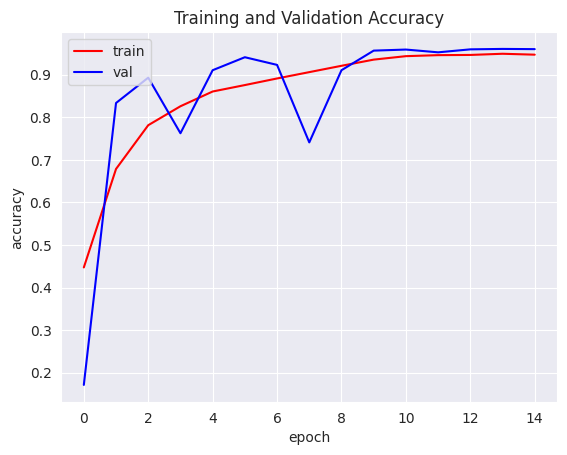

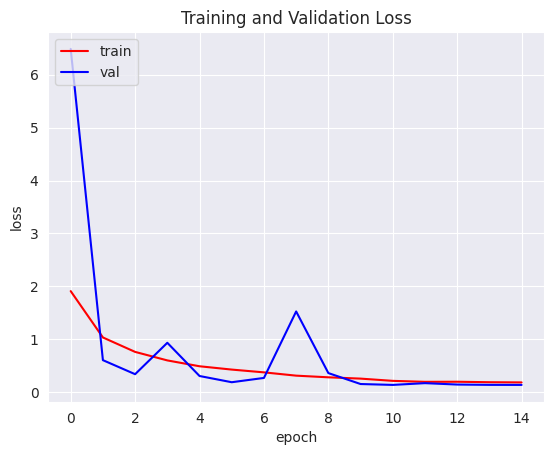

In [ ]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validation Loss')
plt.show()

## Confusion Matrix



                precision    recall  f1-score   support

      Among Us     0.9799    1.0000    0.9898       195
  Apex Legends     0.9466    0.9848    0.9653       198
      Fortnite     0.8884    0.9857    0.9345       210
 Forza Horizon     0.9895    0.9216    0.9543       204
     Free Fire     0.9806    0.9758    0.9782       207
Genshin Impact     0.9538    0.8493    0.8986       219
    God of War     0.9061    0.9461    0.9257       204
     Minecraft     0.9947    0.9947    0.9947       190
        Roblox     0.9835    0.9944    0.9890       180
      Terraria     1.0000    0.9637    0.9815       193

      accuracy                         0.9600      2000
     macro avg     0.9623    0.9616    0.9612      2000
  weighted avg     0.9613    0.9600    0.9598      2000



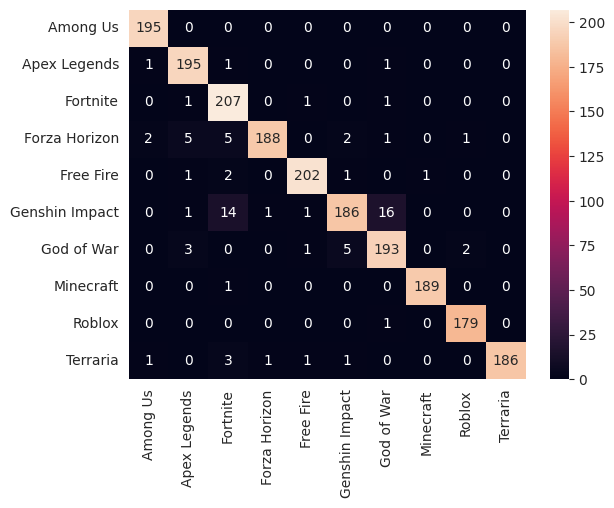

In [ ]:
validation_generator.reset()

preds_1 = model_1.predict(validation_generator,verbose=0)

predicted_labels = np.argmax(preds_1, axis=1)

cm = pd.DataFrame(data=confusion_matrix(validation_generator.classes, predicted_labels),
                  index=train_generator.class_indices,
                  columns=train_generator.class_indices)

sns.heatmap(cm,annot=True,fmt="d")

print("\n")
print(classification_report(y_true=validation_generator.classes,
                            y_pred=predicted_labels,
                            target_names = train_generator.class_indices,
                            digits=4))

# Konversi Model

tf.keras.backend.clear_session()
## SavedModel

In [ ]:
'''tf.keras.backend.clear_session()

save_path = 'mymodel/'
tf.saved_model.save(model_1, save_path)'''

"tf.keras.backend.clear_session()\n\nsave_path = 'mymodel/'\ntf.saved_model.save(model_1, save_path)"

## Tflite

In [ ]:
'''import pathlib

# Convert the model using quantization
converter = tf.lite.TFLiteConverter.from_saved_model(save_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the TFLite model to a file
tflite_model_file = pathlib.Path('vegs_quantized.tflite')
tflite_model_file.write_bytes(tflite_model)
'''

"import pathlib\n\n# Convert the model using quantization\nconverter = tf.lite.TFLiteConverter.from_saved_model(save_path)\nconverter.optimizations = [tf.lite.Optimize.DEFAULT]\ntflite_model = converter.convert()\n\n# Save the TFLite model to a file\ntflite_model_file = pathlib.Path('vegs_quantized.tflite')\ntflite_model_file.write_bytes(tflite_model)\n"

## Tensorflow.js

In [ ]:
#!pip install tensorflowjs

In [ ]:
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model /content/mymodel /content/tfjs_model

/bin/bash: line 1: tensorflowjs_converter: command not found


# Inference

In [ ]:
'''from google.colab import files
uploaded = files.upload()

# Path to your saved model (adjust as necessary)
model_path = '/content/mymodel/'

# Load the model
model = tf.saved_model.load(model_path)

# Prepare input data
img_path = list(uploaded.keys())[0]
img = image.load_img(img_path, target_size=(150, 150), color_mode="grayscale")
input_arr = image.img_to_array(img)
input_arr = np.array([input_arr])
input_arr = input_arr / 255.
infer = model.signatures["serving_default"]
predictions = infer(tf.constant(input_arr))['output_0']

predictions_array = predictions.numpy()
predicted_class = np.argmax(predictions_array)

class_indices_ = validation_generator.class_indices
index_to_class = {v: k for k, v in class_indices_.items()}

predicted_class_name = index_to_class[predicted_class]

plt.figure(figsize=(6, 6))
plt.axis('off')
out = f"I am {max(predictions_array[0]) * 100:.2f}% confident that this is a {predicted_class_name} case"
plt.title("Games Image Recognition\n" + out)
plt.imshow(np.squeeze(input_arr), cmap='gray')  # Ensuring the image is displayed in grayscale
plt.show()'''

'from google.colab import files\nuploaded = files.upload()\n\n# Path to your saved model (adjust as necessary)\nmodel_path = \'/content/mymodel/\'\n\n# Load the model\nmodel = tf.saved_model.load(model_path)\n\n# Prepare input data\nimg_path = list(uploaded.keys())[0]\nimg = image.load_img(img_path, target_size=(150, 150), color_mode="grayscale")\ninput_arr = image.img_to_array(img)\ninput_arr = np.array([input_arr])\ninput_arr = input_arr / 255.\ninfer = model.signatures["serving_default"]\npredictions = infer(tf.constant(input_arr))[\'output_0\']\n\npredictions_array = predictions.numpy()\npredicted_class = np.argmax(predictions_array)\n\nclass_indices_ = validation_generator.class_indices\nindex_to_class = {v: k for k, v in class_indices_.items()}\n\npredicted_class_name = index_to_class[predicted_class]\n\nplt.figure(figsize=(6, 6))\nplt.axis(\'off\')\nout = f"I am {max(predictions_array[0]) * 100:.2f}% confident that this is a {predicted_class_name} case"\nplt.title("Games Image R

In [ ]:
#!pip freeze > requirements.txt